In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
df = pd.read_csv("../data/raw/cleaned_canada.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            44896 non-null  object 
 1   Province        44896 non-null  object 
 2   Latitude        44896 non-null  float64
 3   Longitude       44896 non-null  float64
 4   Price           44896 non-null  float64
 5   Bedrooms        44896 non-null  float64
 6   Bathrooms       44896 non-null  float64
 7   Acreage         44896 non-null  float64
 8   Property Type   44896 non-null  object 
 9   Square Footage  44896 non-null  float64
 10  Garage          44896 non-null  object 
 11  Parking         44896 non-null  object 
 12  Basement        14962 non-null  object 
 13  Exterior        17439 non-null  object 
 14  Fireplace       44896 non-null  object 
 15  Heating         38242 non-null  object 
 16  Flooring        15216 non-null  object 
 17  Roof            10052 non-null 

In [3]:
def find_low_cardinality_columns(df, threshold=10):
    low_card_cols = {}
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) < threshold:
            low_card_cols[col] = list(unique_vals)
    return low_card_cols

low_cardinality_columns = find_low_cardinality_columns(df, threshold=10)
for col, vals in low_cardinality_columns.items():
    print(f"{col}: {vals}")


Property Type: ['Condo', 'Single Family', 'Duplex', 'Townhome', 'Condo/Townhome', 'MultiFamily', 'Mobile Home', 'Manufactured Home', 'Vacant Land']
Garage: ['Yes', 'No']
Parking: ['Yes', 'No']
Basement: ['Finished', 'No basement', 'Partial']
Exterior: ['Metal', 'Vinyl', 'Brick', 'Concrete', 'Composite', 'Wood']
Fireplace: ['No', 'Yes']
Heating: ['heat pump', 'forced air', 'radiant', 'boiler', 'no heat', 'alt heat', 'fireplace', 'space heat', 'other']
Flooring: ['carpet', 'laminate', 'tile', 'wood', 'other', 'vinyl', 'concrete']
Waterfront: ['No', 'Yes']
Sewer: ['municipal', 'septic', 'none', 'alternative', 'private']
Pool: ['No', 'Yes']
Garden: ['No', 'Yes']
Balcony: ['No', 'Yes']


In [4]:
def convert_yes_no_to_binary(df, columns):
    for col in columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    return df

binary_cols = ['Garage', 'Parking', 'Fireplace', 'Waterfront', 'Pool', 'Garden', 'Balcony']
df = convert_yes_no_to_binary(df, binary_cols)


In [5]:
#check columns type
df.dtypes

City               object
Province           object
Latitude          float64
Longitude         float64
Price             float64
Bedrooms          float64
Bathrooms         float64
Acreage           float64
Property Type      object
Square Footage    float64
Garage              int64
Parking             int64
Basement           object
Exterior           object
Fireplace           int64
Heating            object
Flooring           object
Roof               object
Waterfront          int64
Sewer              object
Pool                int64
Garden              int64
Balcony             int64
dtype: object

In [6]:
#calculate missing value and Na value in each column
df.isnull().sum()


City                  0
Province              0
Latitude              0
Longitude             0
Price                 0
Bedrooms              0
Bathrooms             0
Acreage               0
Property Type         0
Square Footage        0
Garage                0
Parking               0
Basement          29934
Exterior          27457
Fireplace             0
Heating            6654
Flooring          29680
Roof              34844
Waterfront            0
Sewer                 0
Pool                  0
Garden                0
Balcony               0
dtype: int64

In [7]:
#check property type
df["Property Type"].unique()

array(['Condo', 'Single Family', 'Duplex', 'Townhome', 'Condo/Townhome',
       'MultiFamily', 'Mobile Home', 'Manufactured Home', 'Vacant Land'],
      dtype=object)

In [8]:
def property_type_missing_value(df,property_type):

    df = df.replace(["", " ", "None", "none", "null", "Null", "NULL"], np.nan)

    condo_df= df[df["Property Type"] == property_type]
    missing_percentage = (condo_df.isnull().sum() / len(condo_df)*100).round(2)
    for col, percent in missing_percentage.items():
        (f"{col}: {percent}%")
    
    return missing_percentage

In [9]:
property_type_missing_value(df,"Condo")

property_type_missing_value(df,"Townhome")


City                0.00
Province            0.00
Latitude            0.00
Longitude           0.00
Price               0.00
Bedrooms            0.00
Bathrooms           0.00
Acreage             0.00
Property Type       0.00
Square Footage      0.00
Garage              0.00
Parking             0.00
Basement          100.00
Exterior           98.48
Fireplace           0.00
Heating             9.75
Flooring           81.90
Roof               78.59
Waterfront          0.00
Sewer              90.75
Pool                0.00
Garden              0.00
Balcony             0.00
dtype: float64

In [10]:
def remove_outlier_IQR(df, group_col, target_cols):
    result = pd.DataFrame()

    for ptype in df[group_col].unique():
        sub_df = df[df[group_col] == ptype].copy()
        
        for col in target_cols:
            Q1 = sub_df[col].quantile(0.25)
            Q3 = sub_df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            sub_df = sub_df[(sub_df[col] >= lower_bound) & (sub_df[col] <= upper_bound)]
        
        result = pd.concat([result, sub_df], ignore_index=True)
    
    return result
    

In [11]:
df_cleaned = remove_outlier_IQR(df, group_col='Property Type', target_cols=['Price', 'Square Footage'])


In [12]:
#df vs df_cleaned
df.info()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44896 entries, 0 to 44895
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            44896 non-null  object 
 1   Province        44896 non-null  object 
 2   Latitude        44896 non-null  float64
 3   Longitude       44896 non-null  float64
 4   Price           44896 non-null  float64
 5   Bedrooms        44896 non-null  float64
 6   Bathrooms       44896 non-null  float64
 7   Acreage         44896 non-null  float64
 8   Property Type   44896 non-null  object 
 9   Square Footage  44896 non-null  float64
 10  Garage          44896 non-null  int64  
 11  Parking         44896 non-null  int64  
 12  Basement        14962 non-null  object 
 13  Exterior        17439 non-null  object 
 14  Fireplace       44896 non-null  int64  
 15  Heating         38242 non-null  object 
 16  Flooring        15216 non-null  object 
 17  Roof            10052 non-null 

In [13]:
df_cleaned.head()

,City,Province,Latitude,Longitude,Price,Bedrooms,Bathrooms,Acreage,Property Type,Square Footage,...,Exterior,Fireplace,Heating,Flooring,Roof,Waterfront,Sewer,Pool,Garden,Balcony
0,Revelstoke,BC,50.976585,-118.173149,839000.0,3.0,2.0,0.0,Condo,891.0,...,NaN,0,heat pump,carpet,NaN,0,municipal,0,0,0
1,Maple Ridge,BC,49.221673,-122.596637,759900.0,3.0,2.0,0.0,Condo,1254.0,...,NaN,0,radiant,NaN,NaN,0,none,0,0,0
2,Qualicum Beach,BC,49.346396,-124.444500,549000.0,2.0,2.0,0.0,Condo,1122.0,...,NaN,0,radiant,tile,NaN,0,municipal,0,1,0
3,Okotoks,AB,50.707067,-113.971362,289900.0,2.0,2.0,0.0,Condo,846.0,...,NaN,1,radiant,carpet,NaN,0,none,0,0,0
4,Calgary,AB,51.041975,-114.073182,489000.0,2.0,2.0,0.0,Condo,1044.0,...,NaN,0,NaN,laminate,NaN,0,none,0,0,1


In [15]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40449 entries, 0 to 40448
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   City            40449 non-null  object 
 1   Province        40449 non-null  object 
 2   Latitude        40449 non-null  float64
 3   Longitude       40449 non-null  float64
 4   Price           40449 non-null  float64
 5   Bedrooms        40449 non-null  float64
 6   Bathrooms       40449 non-null  float64
 7   Acreage         40449 non-null  float64
 8   Property Type   40449 non-null  object 
 9   Square Footage  40449 non-null  float64
 10  Garage          40449 non-null  int64  
 11  Parking         40449 non-null  int64  
 12  Basement        14496 non-null  object 
 13  Exterior        16737 non-null  object 
 14  Fireplace       40449 non-null  int64  
 15  Heating         34374 non-null  object 
 16  Flooring        14565 non-null  object 
 17  Roof            9754 non-null  

In [16]:
cat_columns = [
    'City', 'Province', 'Property Type', 'Basement', 'Exterior',
    'Heating', 'Flooring', 'Roof', 'Sewer'
]

for col in cat_columns:
    df_cleaned[col] = df_cleaned[col].astype('category')

In [17]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

target = 'Price'
features = [col for col in df_cleaned.columns if col != target]

X_train, X_test, y_train, y_test = train_test_split(df_cleaned[features], df_cleaned[target], test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=6,
    tree_method='hist',
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=True
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 43975984537.27903
R-squared: 0.8712868249267743


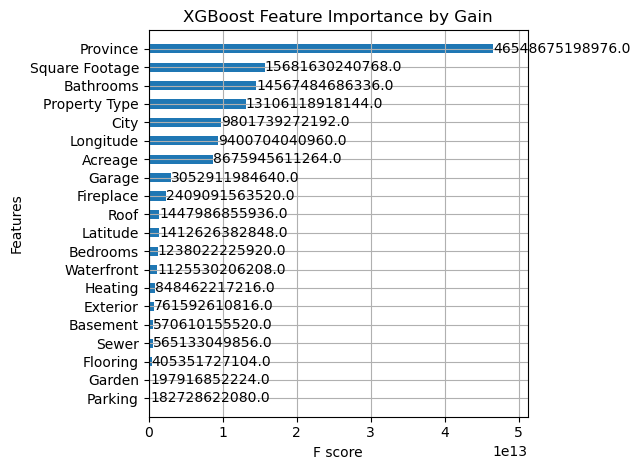

In [18]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, importance_type='gain', max_num_features=20, height=0.5, title='XGBoost Feature Importance by Gain')
plt.tight_layout()
plt.show()

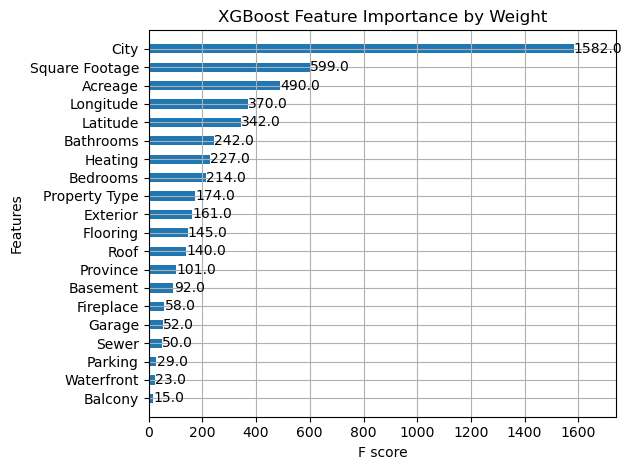

In [19]:
xgb.plot_importance(model, importance_type='weight', max_num_features=20, height=0.5, title='XGBoost Feature Importance by Weight')
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import cross_val_score, KFold  
from sklearn.metrics import make_scorer

mse_scorer= make_scorer(mean_squared_error, greater_is_better=False)

kf= KFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, df_cleaned[features], df_cleaned[target], 
                            cv=kf, scoring='r2')
print("Cross-Validated R2 (each fold):", cv_scores)
print("Average CV R2:", np.mean(cv_scores))


Cross-Validated R2 (each fold): [0.87313494 0.86175722 0.87394831 0.86644272 0.86687734]
Average CV R2: 0.868432105759835
